#### Problem Statement

1) Describe the data set and eventual anomalies you find.    
2) Which patterns do you find in the purchasing behavior of the customer?            
3) What are the categories and genres which customers are mostly intrested in?     
4) Split the customers in different groups based on their purchasing behavior.     
   a) Justify your choice for adopted method(s) and model(s).                          
   b) Describe the defined customer groups. What are the features which are driving the differentiation amongst the different groups?    
   c) Give suggestions how the business should treat these clusters differently.        
5) Assuming that the 'Category_Reporting' tells you the category of all the items in that order, predic:    
   a) The number of items per category which will be ordered on a monthly basis for rest of May 2021.    
   b) The number of returns for the rest of May 2021.      
6) As, at this point in your analysis you are the dataset expert, suggest any ideas (initiatives, further analysis) you might have in mind which can be helpful for the business.    
   

In [2]:
# loading packages
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter



from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .config("spark.executor.cores","3")\
    .config("spark.executor.instance","12")\
    .config('spark.sql.shuffle.partitions',"128")\
    .config("spark.debug.maxToStringsFields","100")\
    .appName("Customer Segmentation") \
    .getOrCreate()

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

In [29]:
# reading the data set
df = spark.read.csv(r"C:\Users\Owner\OneDrive\Desktop\Python Code\EMP Systems\EMP_DataScientist_CS\Data\EMPCaseStudy_v1.csv",header =True)

In [30]:
df.show(3)

+--------------------+--------------------+------------+------+-----------+---------------------+--------------------+-------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+----------+-------------+--------------+------------+--------------+-----------+-------------+
|        CustomerHash|           OrderHash|Customer_Age|Gender|Account_Age|AffinityProductGender|  Category_Reporting|        Genre|ClientType|PartnerProgram1|PartnerProgram2|FirstOrder|Marketing_Channel|Pieces_Ordered|Pieces_Outbound|Pieces_Returns|Pieces_Fulfilled|OrderValue|Revenue_Goods|Delivery_Value|Return_Value|Discount_Total|OrderProfit|DateTimeOrder|
+--------------------+--------------------+------------+------+-----------+---------------------+--------------------+-------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+---------

In [37]:
# printing shape of provided data set
print("Total number of rows:",df.count() ,"and total number of columns in dataset are:",len(df.columns))

Total number of rows: 1119023 and total number of columns in dataset are: 24


In [42]:
import pyspark.sql.functions as funcs
# finding total number of duplicate values in data set if any
print('Total number of duplicate values in the data set is/are:')

df.groupBy(df.columns)\
    .count()\
    .where(funcs.col('count') > 1)\
    .select(funcs.sum('count'))\
    .show()

Total number of duplicate values in the data set is/are:
+----------+
|sum(count)|
+----------+
|      null|
+----------+



In [43]:
# # finding total number of duplicate values in data set if any
# print('Total number of duplicate values in the data set is/are: {}'.format(df.duplicated().sum()))

In [49]:
import pyspark.sql.functions as F
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------+---------+------------+------+-----------+---------------------+------------------+-----+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+----------+-------------+--------------+------------+--------------+-----------+-------------+
|CustomerHash|OrderHash|Customer_Age|Gender|Account_Age|AffinityProductGender|Category_Reporting|Genre|ClientType|PartnerProgram1|PartnerProgram2|FirstOrder|Marketing_Channel|Pieces_Ordered|Pieces_Outbound|Pieces_Returns|Pieces_Fulfilled|OrderValue|Revenue_Goods|Delivery_Value|Return_Value|Discount_Total|OrderProfit|DateTimeOrder|
+------------+---------+------------+------+-----------+---------------------+------------------+-----+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+----------+-------------+--------------+------------+--------------+-----------+-------------+
|

In [50]:
# # checking for null values in the data set
# col = df.columns
# for i in col:
#     # count number of rows with missing values
#     n_miss = df[[i]].isNull().sum()
#     perc = n_miss / df.shape[0] * 100
#     print('%s, Missing: %d (%.1f%%)' % (i, n_miss, perc))

In [52]:
# Checking the rows where Pieces_Outbound is missing. This row represents the total number of items shipped to the customer.
df[df["Pieces_Outbound"].isNull()].show()

+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+----------+-------------+--------------+------------+--------------+-----------+-------------+
|        CustomerHash|           OrderHash|Customer_Age|   Gender|Account_Age|AffinityProductGender|  Category_Reporting|               Genre|ClientType|PartnerProgram1|PartnerProgram2|FirstOrder|Marketing_Channel|Pieces_Ordered|Pieces_Outbound|Pieces_Returns|Pieces_Fulfilled|OrderValue|Revenue_Goods|Delivery_Value|Return_Value|Discount_Total|OrderProfit|DateTimeOrder|
+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+-----------

In [53]:
# Checking the rows where Pieces_Outbound is missing. This row represents the total number of items actually fulfilled after returns.
df[df["Pieces_Fulfilled"].isNull()].show()

+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+----------+-------------+--------------+------------+--------------+-----------+-------------+
|        CustomerHash|           OrderHash|Customer_Age|   Gender|Account_Age|AffinityProductGender|  Category_Reporting|               Genre|ClientType|PartnerProgram1|PartnerProgram2|FirstOrder|Marketing_Channel|Pieces_Ordered|Pieces_Outbound|Pieces_Returns|Pieces_Fulfilled|OrderValue|Revenue_Goods|Delivery_Value|Return_Value|Discount_Total|OrderProfit|DateTimeOrder|
+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+-----------

In [54]:
# Checking the rows where Pieces_Outbound is missing. This row represents the fullfilled OrderValue after returns.
df[df["Revenue_Goods"].isNull()].show()

+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+----------+-------------+--------------+------------+--------------+-----------+-------------+
|        CustomerHash|           OrderHash|Customer_Age|   Gender|Account_Age|AffinityProductGender|  Category_Reporting|               Genre|ClientType|PartnerProgram1|PartnerProgram2|FirstOrder|Marketing_Channel|Pieces_Ordered|Pieces_Outbound|Pieces_Returns|Pieces_Fulfilled|OrderValue|Revenue_Goods|Delivery_Value|Return_Value|Discount_Total|OrderProfit|DateTimeOrder|
+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+-----------

In [55]:
# Checking the rows where Pieces_Outbound is missing. This row represents the value of delivered items.
df[df["Delivery_Value"].isNull()].show()

+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+----------+-------------+--------------+------------+--------------+-----------+-------------+
|        CustomerHash|           OrderHash|Customer_Age|   Gender|Account_Age|AffinityProductGender|  Category_Reporting|               Genre|ClientType|PartnerProgram1|PartnerProgram2|FirstOrder|Marketing_Channel|Pieces_Ordered|Pieces_Outbound|Pieces_Returns|Pieces_Fulfilled|OrderValue|Revenue_Goods|Delivery_Value|Return_Value|Discount_Total|OrderProfit|DateTimeOrder|
+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+-----------

In [56]:
# Checking the rows where OrderProfit is missing. This row represents the total profit from the order.
df[df["OrderProfit"].isNull()].show()

+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+--------------+----------------+----------+-------------+--------------+------------+--------------+-----------+-------------+
|        CustomerHash|           OrderHash|Customer_Age|   Gender|Account_Age|AffinityProductGender|  Category_Reporting|               Genre|ClientType|PartnerProgram1|PartnerProgram2|FirstOrder|Marketing_Channel|Pieces_Ordered|Pieces_Outbound|Pieces_Returns|Pieces_Fulfilled|OrderValue|Revenue_Goods|Delivery_Value|Return_Value|Discount_Total|OrderProfit|DateTimeOrder|
+--------------------+--------------------+------------+---------+-----------+---------------------+--------------------+--------------------+----------+---------------+---------------+----------+-----------------+--------------+---------------+-----------

From the data set we can see that their is no duplicate values but their are few missing values which we have to handle before applying our ML algorithm.   
1) We can see that almost 80% of data is missing in Pieces_Returns and simmillarly, 80% in Return_Value.   
2) There is 29.2% data is missing in customer age column to impute these values we will use KNNImputer considering the values are missing at random.    
3) ClientType 1% of data is missing may be we can drop the rows where the client type is missing since we have big data set.   
4) We have 2% missing data in Pieces_Outbound.    
5) We have 2% missing data in Pieces_Fulfilled.    
6) We have 2% missing data in Revenue_Goods.   
7) We have 2% missing data in Delivery_Value.    
8) We have 2% missing data in OrderProfit.    
##### Assumption:    
1) I assume that for missing values in these fields (Pieces_Returns and Return_Value) meaning that no item has been returned so if no item is returned than no return value. In this case I will mark all the missing values with zero.     
2) For Pieces_Outbound, this column represents the total number of items shipped to the customer so missing values means no item are shipped to the customer. We will drop these rows where Pieces_Otbound is missing since some of the items were ordered in 2019. I think other features (Pieces_Fulfilled, Revenue_Godds, Deliver_Value and OrderProfit) are also dependent on this so may be after droping rows for Pieces_Outbound we may not have to impute these features so we will first drop the rows and then see again if we need any imputation.

In [57]:
# droping rows with missing values in Pieces_Outbound, Marketing_Channel, ClientType
df1 = df.dropna(subset=['Pieces_Outbound','Marketing_Channel','ClientType'])

In [59]:
# imputing the columns with 0 considering their is no return.
col_impute = ['Pieces_Returns','Return_Value']
df1 = df1.fillna({'Pieces_Returns':0,'Return_Value':0})

In [60]:
# # checking for null values in the data set
# col = df1.columns
# for i in col:
#     # count number of rows with missing values
#     n_miss = df1[[i]].isnull().sum()
#     perc = n_miss / df1.shape[0] * 100
#     print('%s, Missing: %d (%.1f%%)' % (i, n_miss, perc))

In [61]:
# Checking types of features in the dataset
df1.dtypes

[('CustomerHash', 'string'),
 ('OrderHash', 'string'),
 ('Customer_Age', 'string'),
 ('Gender', 'string'),
 ('Account_Age', 'string'),
 ('AffinityProductGender', 'string'),
 ('Category_Reporting', 'string'),
 ('Genre', 'string'),
 ('ClientType', 'string'),
 ('PartnerProgram1', 'string'),
 ('PartnerProgram2', 'string'),
 ('FirstOrder', 'string'),
 ('Marketing_Channel', 'string'),
 ('Pieces_Ordered', 'string'),
 ('Pieces_Outbound', 'string'),
 ('Pieces_Returns', 'string'),
 ('Pieces_Fulfilled', 'string'),
 ('OrderValue', 'string'),
 ('Revenue_Goods', 'string'),
 ('Delivery_Value', 'string'),
 ('Return_Value', 'string'),
 ('Discount_Total', 'string'),
 ('OrderProfit', 'string'),
 ('DateTimeOrder', 'string')]

In [64]:
# droping customer id and order id as we will not be using these for our clustering
df1 = df1.drop('CustomerHash','OrderHash','DateTimeOrder')
# df1.drop('DateTimeOrder',inplace = True,axis =1)

In [66]:
# print('Gender: ',df1.Gender.unique())
# print('\nAffinity Product Gender: ',df1.AffinityProductGender.unique())
# print('\nReporting Category: ',df1.Category_Reporting.unique())
# print('\nGenre: ',df1.Genre.unique())
# print('\nClient Type: ',df1.ClientType.unique())
# print('\nPartner Program1: ',df1.PartnerProgram1.unique())
# print('\nPartner Program2: ',df1.PartnerProgram2.unique())
# print('\nMarketing Channel: ',df1.Marketing_Channel.unique())

In [70]:
df1.select("Gender").distinct().show()
df1.select("AffinityProductGender").distinct().show()
df1.select("Category_Reporting").distinct().show()
df1.select("Genre").distinct().show()
df1.select("ClientType").distinct().show()
df1.select("PartnerProgram1").distinct().show()
df1.select("PartnerProgram2").distinct().show()
df1.select("Marketing_Channel").distinct().show()


# print('\nAffinity Product Gender: ',df1.AffinityProductGender.unique())
# print('\nReporting Category: ',df1.Category_Reporting.unique())
# print('\nGenre: ',df1.Genre.unique())
# print('\nClient Type: ',df1.ClientType.unique())
# print('\nPartner Program1: ',df1.PartnerProgram1.unique())
# print('\nPartner Program2: ',df1.PartnerProgram2.unique())
# print('\nMarketing Channel: ',df1.Marketing_Channel.unique())

+---------+
|   Gender|
+---------+
|      Man|
|Undefined|
|    Woman|
+---------+

+---------------------+
|AffinityProductGender|
+---------------------+
|                 Male|
|               Female|
|               Unisex|
+---------------------+

+--------------------+
|  Category_Reporting|
+--------------------+
|     Music - Apparel|
|Entertainment - A...|
|Fashion - Accesso...|
|            Freebies|
|Funshirts&Hoodies...|
|          Warner D2C|
|Fashion / Private...|
|      BSC Membership|
|Entertainment - A...|
|    Gaming - Apparel|
|               Media|
| Music - Accessories|
|Gaming - Accessories|
|Fashion / 3rd Par...|
+--------------------+

+--------------------+
|               Genre|
+--------------------+
| Merchandise - Music|
|   Merchandise - Fun|
| Merchandise - Other|
|          Warner D2C|
|    3rd Party Brands|
|       Private label|
|               Other|
|Merchandise - Fil...|
| Merchandise - Games|
+--------------------+

+----------+
|ClientType|
+----

In [72]:
# # converting Gender from object type to int
# df1.Gender = df1.Gender.replace({'Man':1, 'Woman':2,'Undefined':3})

In [75]:
# converting Gender from object type to int
df1 = df1.withColumn('Gender', F.when(df1.Gender == 'Man', 1).otherwise(
      F.when(df1.Gender == 'Woman',2).otherwise(3)
))

In [72]:
# # converting Affinity Product Gender from object type to int
# df1.AffinityProductGender = df1.AffinityProductGender.replace({'Male':1, 'Female':2,'Unisex':3})

In [76]:
# converting Affinity Product Gender from object type to int
df1 = df1.withColumn('AffinityProductGender', F.when(df1.AffinityProductGender == 'Male', 1).otherwise(
      F.when(df1.AffinityProductGender == 'Female',2).otherwise(3)
))

In [73]:
# converting Affinity Product Gender from object type to int
df1.Category_Reporting = df1.Category_Reporting.replace({'Fashion / Private label - Apparel':1, 'Warner D2C':2,
                                                          'BSC Membership':3, 'Entertainment - Apparel':4,
                                                          'Media':5, 'Funshirts&Hoodies - Apparel':6,
                                                          'Music - Apparel':7, 'Fashion - Accessories':8,
                                                          'Fashion / 3rd Party - Apparel':9, 'Entertainment - Accessories':10,
                                                          'Gaming - Accessories':11, 'Gaming - Apparel':12,
                                                          'Music - Accessories':13, 'Freebies':14                                                                                                                                    
                                                         })

In [74]:
# converting Affinity Product Gender from object type to int
df1.Genre = df1.Genre.replace({'Private label':1, 'Warner D2C':2, 'Other':3, 'Merchandise - Film & TV':4,
                                             'Merchandise - Music':5, 'Merchandise - Fun':6, '3rd Party Brands':7,
                                             'Merchandise - Other':8, 'Merchandise - Games':9
                                            })

In [75]:
# # converting Affinity Product Gender from object type to int
# df1.ClientType = df1.ClientType.replace({'desktop':1, 'mobile':2, 'app':3})

In [77]:
# converting Affinity Product Gender from object type to int
df1 = df1.withColumn('ClientType', F.when(df1.ClientType == 'desktop', 1).otherwise(
      F.when(df1.ClientType == 'mobile',2).otherwise(3)
))

In [76]:
# # converting Affinity Product Gender from object type to int
# df1.PartnerProgram1 = df1.PartnerProgram1.replace({'No':0, 'Yes':1})

In [78]:
# converting Affinity Product Gender from object type to int
df1 = df1.withColumn('PartnerProgram1', F.when(df1.PartnerProgram1 == 'No', 0).otherwise(1))

In [77]:
# # converting Affinity Product Gender from object type to int
# df1.PartnerProgram2 = df1.PartnerProgram2.replace({'No':0, 'Yes':1})

In [79]:
# converting Affinity Product Gender from object type to int
df1 = df1.withColumn('PartnerProgram2', F.when(df1.PartnerProgram2 == 'No', 0).otherwise(1))

In [78]:
# converting Affinity Product Gender from object type to int
df1.Marketing_Channel = df1.Marketing_Channel.replace({'direct':1, 'seo':2, 'newsletter':3, 'sea nonbrand':4,
                                                         'pla':5, 'sea brand':6, 'retargeting':7, 'social media':8,
                                                         'marketplaces':9, 'affiliating':10, 'social referrer':11,
                                                         'social ads':12, 'unknown':13, 'referrer':14, 'mc':15,
                                                         'partner program':16, 'other om campaigns':17, 'display':18,
                                                         'Payback':19
                                                        })

In [79]:
# # Ploting Sale for age and Tenure
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
# df_train['Tenure_Bins'] = pd.cut(df_train['Tenure'], bins = [0,50,100,150,200,250,300])
# df_train['Age_Bins'] = pd.cut(df_train['Age'], bins = [0,40,60,80,100])
# sns.countplot(df_train[df_train['Sale_CL']==1]['Tenure_Bins'], hue=df_train[df_train['Sale_CL']==1]["Sex"] ,ax=ax1);
# sns.countplot(df_train[df_train['Sale_CL']==1]['Age_Bins'], hue=df_train[df_train['Sale_CL']==1]["Sex"], ax=ax2);
# df_train.drop(labels=['Tenure_Bins','Age_Bins'], axis=1, inplace=True)

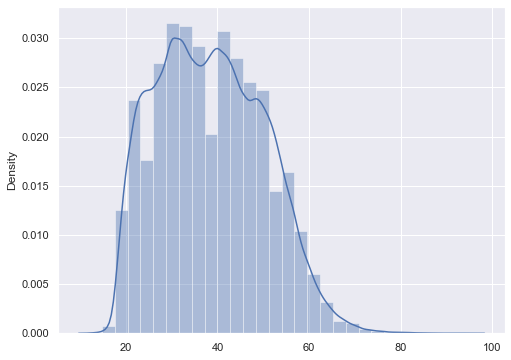

In [94]:
# density plot with Age of customer
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,6)})
my_list = df.select(F.collect_list('Customer_Age')).first()[0]
sns.distplot(my_list, bins=30);

In [ ]:
# imputing with KNNImputer
cols1 = df1.columns
k = math.sqrt(df1.shape[0])
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# df_train.Age = df_train.Age.replace('Age<=10',np.nan,regex=True)
# df.Customer_Age = df.Customer_Age.mask(df.Customer_Age <= 10)
df1[cols1] = imputer.fit_transform(df1.values)

In [85]:
math.sqrt(df1.shape[0])

1042.5607895945445

In [89]:
df1['Customer_Age'].getItem(0)

Column<b'Customer_Age[0]'>

In [91]:
my_list = df.select(F.collect_list('Customer_Age')).first()[0]

In [93]:
# my_list